In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import os
from json import loads
import plotly.express as px

Helper functions to search for school

In [2]:
school_df = pd.read_csv("schoolname_UNITID.csv")

def search_school(school_name):
    # Case-insensitive search for school name
    result = school_df[school_df["inst_name"].str.contains(school_name, case=False, na=False)]
    if result.empty:
        print(f"No matches found for '{school_name}'.")
    return result

def get_school_name(unitid):
    # Fetch school directory data
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?unitid={unitid}"
    response = urlopen(url)
    data = loads(response.read())
    
    results = data.get("results", [])
    if results:
        school_name = results[0].get("inst_name", "Unknown")
        return school_name
    else:
        return f"No school found for unitid {unitid}"

def search_school_by_state(state_abbr):
    """Search for schools in a given state (by abbreviation) and return a DataFrame with unitid and school name.
    """
    url = "https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/"
    
    try:
        response = urlopen(url)
        data = loads(response.read())
        results = data.get("results", [])
        
        if not results:
            print(f"No schools found.")
            return pd.DataFrame()
        
        # Filter results manually based on state_abbr
        filtered_results = [
            {"unitid": result.get("unitid"), "school_name": result.get("inst_name", "Unknown")}
            for result in results if result.get("state_abbr") == state_abbr.upper()
        ]
        
        if not filtered_results:
            print(f"No schools found in {state_abbr}.")
            return pd.DataFrame()
        
        return pd.DataFrame(filtered_results)
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()
        

In [7]:
search_school_by_state("nj")

,unitid,school_name
0,183488,Eastwick College-Hackensack
1,183600,Assumption College for Sisters
2,183655,Atlantic Cape Community College
3,183725,Fortis Institute-Wayne
4,183743,Bergen Community College
...,...,...
160,493628,Pro Beauty Academy
161,493707,Yeshiva Gedolah of Woodlake Village
162,493716,Yeshiva Gedola Tiferes Yaakov Yitzchok
163,495314,Hackensack Meridian School of Medicine


Get a UNITIDs of New Jersey schools

In [3]:
NJ_schools = search_school_by_state("nj")

if not NJ_schools.empty:
    # Extract the list of unitid values
    NJ_unitid_list = NJ_schools["unitid"].tolist()
    print("List of UNITIDs for schools in New Jersey:", NJ_unitid_list)

    # Fetch and print school names for each unitid
    for unitid in NJ_unitid_list:
        school_name = get_school_name(unitid)
        print(f"UNITID: {unitid}, School Name: {school_name}")
else:
    print("No schools found in New Jersey.")

List of UNITIDs for schools in New Jersey: [183488, 183600, 183655, 183725, 183743, 183789, 183804, 183822, 183859, 183877, 183910, 183938, 183974, 183983, 184047, 184056, 184092, 184180, 184205, 184278, 184348, 184427, 184481, 184506, 184603, 184612, 184694, 184746, 184773, 184782, 184791, 184816, 184870, 184959, 184968, 184995, 185129, 185174, 185262, 185332, 185396, 185466, 185509, 185536, 185572, 185590, 185679, 185721, 185758, 185767, 185828, 185873, 185970, 186016, 186034, 186052, 186122, 186131, 186186, 186201, 186283, 186371, 186380, 186399, 186405, 186423, 186432, 186469, 186584, 186593, 186618, 186645, 186867, 186876, 186900, 187000, 187046, 187134, 187198, 187444, 194718, 245625, 247603, 249140, 363077, 365763, 368230, 374574, 374592, 383279, 384421, 407391, 407407, 407425, 414063, 417831, 420130, 420343, 421878, 430218, 430403, 431716, 436003, 437723, 440794, 441548, 442073, 443216, 443225, 445300, 446224, 446303, 448354, 448983, 449658, 451370, 451398, 453215, 455187, 4551

In [4]:
def process_graduation_data(unitid, folder_path="grad"):
    """
    Process graduation rate data for a given unitid across files like gr2022.csv, gr20233.csv.
    """
    variable_mapping = {
        "GRTYPE": "Cohort_type",
        "CHRTSTAT": "Graduation_rate_status_in_cohort",
        "COHORT": "Cohort",
        "GRTOTLT": "Total",
        "GRTOTLM": "Total_men",
        "GRTOTLW": "Total_women",
        "GRAIANT": "American_Indian_total",
        "GRAIANM": "American_Indian_men",
        "GRAIANW": "American_Indian_women",
        "GRASIAT": "Asian_total",
        "GRASIAM": "Asian_men",
        "GRASIAW": "Asian_women",
        "GRBKAAT": "Black_total",
        "GRBKAAM": "Black_men",
        "GRBKAAW": "Black_women",
        "GRHISPT": "Hispanic_total",
        "GRHISPM": "Hispanic_men",
        "GRHISPW": "Hispanic_women",
        "GRNHPIT": "Native_Hawaiian_total",
        "GRNHPIM": "Native_Hawaiian_men",
        "GRNHPIW": "Native_Hawaiian_women",
        "GRWHITT": "White_total",
        "GRWHITM": "White_men",
        "GRWHITW": "White_women",
        "GR2MORT": "Two_or_more_races_total",
        "GR2MORM": "Two_or_more_races_men",
        "GR2MORW": "Two_or_more_races_women",
        "GRUNKNT": "Race_unknown_total",
        "GRUNKNM": "Race_unknown_men",
        "GRUNKNW": "Race_unknown_women",
        "GRNRALT": "Nonresident_alien_total",
        "GRNRALM": "Nonresident_alien_men",
        "GRNRALW": "Nonresident_alien_women",
    }

    dataframes = []

    for filename in os.listdir(folder_path):
        if not filename.startswith("gr") or not filename.endswith(".csv") or filename.endswith("_dict.csv"):
            continue

        # Extract year from filename
        year_digits = ''.join(filter(str.isdigit, filename))
        year = int(year_digits[:4])  # '20233' -> 2023

        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        df = df[df["UNITID"] == unitid]
        selected_cols = [col for col in df.columns if col in variable_mapping]

        if not selected_cols:
            continue

        df = df[selected_cols].copy()
        df["year"] = year
        df["unitid"] = unitid
        df["university_name"] = get_school_name(unitid)
        df.rename(columns=variable_mapping, inplace=True)

        dataframes.append(df)

    if not dataframes:
        print(f"No graduation data found for unitid {unitid}.")
        return pd.DataFrame()

    final_df = pd.concat(dataframes, ignore_index=True)
    col_order = ["unitid", "university_name", "year"] + [col for col in final_df.columns if col not in ["unitid", "university_name", "year"]]
    return final_df[col_order]


In [5]:
all_data = pd.DataFrame()
for unitid in NJ_unitid_list:
    unitid_data = process_graduation_data(unitid)
    if not unitid_data.empty:
        all_data = pd.concat([all_data, unitid_data], ignore_index=True)

output_path = "grad/NJ_graduation_data.csv"
all_data.to_csv(output_path, index=False)

print(f"All data saved to: {output_path}")

All data saved to: grad/NJ_graduation_data.csv


In [30]:
def plot_graduation_funnel(df, selected_unitid=None, selected_year=None):
    # Filter if needed
    if selected_unitid:
        df = df[df["UNITID"] == selected_unitid]
    if selected_year:
        df = df[df["year"] == selected_year]

    # Define CHRTSTAT codes and their funnel stage labels
    funnel_stages = {
        12: "Adjusted Cohort",       # Enrolled students (after exclusions)
        22: "Completed in 100%",     # Graduated within 100% of normal time
        13: "Completed in 150%",     # Graduated within 150% of normal time
        20: "Transferred Out"        # Transfer-out students
    }

    # Aggregate totals for each stage
    stage_names = []
    student_counts = []

    for code, label in funnel_stages.items():
        count = df[df["Graduation_rate_status_in_cohort"] == code]["Total"].sum()
        stage_names.append(label)
        student_counts.append(count)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(stage_names[::-1], student_counts[::-1], color="#2ca02c")

    for bar in bars:
        width = bar.get_width()
        ax.text(width + max(student_counts) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}', va='center', fontsize=10)

    ax.set_title("Graduation Funnel", fontsize=14, fontweight='bold')
    ax.set_xlabel("Number of Students")
    ax.set_ylabel("Cohort Status")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


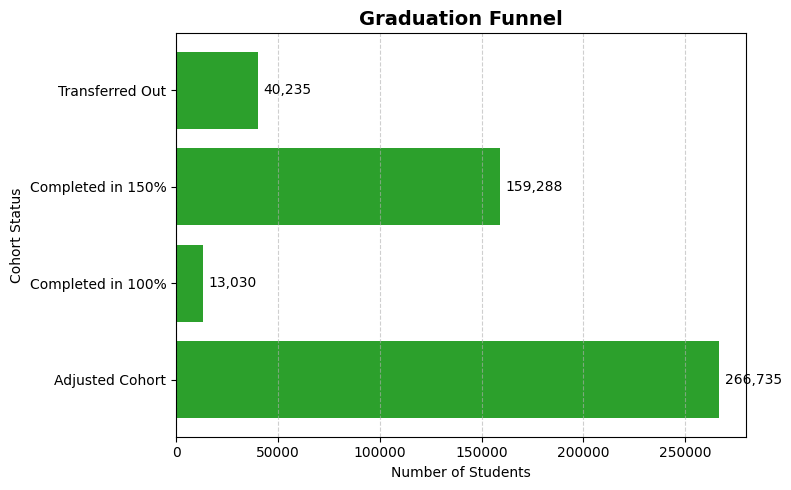

In [31]:

df_grads = pd.read_csv("grad/NJ_graduation_data.csv")
plot_graduation_funnel(df_grads)
